In [1]:
import matplotlib.pyplot as plt
import numpy as np
from retrain_ablooper import *
import torch
import pandas as pd

In [2]:
def compare(rmsds):
    ablooper_chothia = np.array([0.90, 1.03, 2.45, 0.61, 0.51, 0.93])
    dif = rmsds[0] - ablooper_chothia

    dic = {'Chothia': ablooper_chothia,
           'IMGT': rmsds[0],
           '\u0394': dif}

    df = pd.DataFrame.from_dict(dic, orient='index', columns=['H1','H2','H3','L1','L2','L3']).round(decimals=2)
    return df

**3.1 Model trained on 16-04, 1 decoy, optimiser: RAdam, 268 epochs, batch size = 1**

Plot losses

In [3]:
def get_loss(loss_text, **kwargs):
    if kwargs['loss'] == 'train':
        which = 0
    elif kwargs['loss'] == 'val':
        which = 1
    
    losses = []
    loss_text = loss_text[1:] # remove header
    for i in range(len(loss_text)):
        losses.append(float(loss_text[i].strip().split('|')[which]))
    
    return np.asarray(losses)

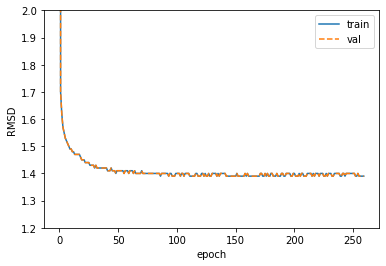

In [4]:
with open('losses_1604.out', 'r') as f:
    text = f.readlines()
loss_text = text[4:]

train_loss = get_loss(loss_text, loss='train')
val_loss = get_loss(loss_text, loss='val')

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1.2,2))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-1604.png')

Get rmsd for each CDR on val set with best weights

In [5]:
# initialise model
model = MaskDecoyGen(decoys=1).to(device = device).float()
model.load_state_dict(torch.load("best_model1604", map_location=torch.device(device)))

<All keys matched successfully>

In [6]:
def cdr_rmsd_val_set(decoys, val_dataloader):
    '''
    Calculates the mean rmsd per cdr for a validation set
    '''
    CDRs = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']
    cdr_rmsds = torch.zeros(decoys, 100, len(CDRs))
    
    with torch.no_grad():
        model.eval() 

        for i, data in enumerate(val_dataloader):
            node_features = data['encodings']
            coordinates = data['geomins']
            out_coordinates = data['geomouts']
            mask = data['mask']

            pred = model(node_features, coordinates, mask)

            cdr_rmsds[:,i,:] = rmsd_per_cdr(pred, node_features, out_coordinates, CDRs, decoys)

        return cdr_rmsds.mean(1)

In [7]:
# Does not run in this notebook but results shon below
# (see retrain_model.ipynb for working code)
# cdr_rmsd = cdr_rmsd_val_set(1, val_dataloader)
# print('H1, H2, H3, L1, L2, L3')
# cdr_rmsd

H1, H2, H3, L1, L2, L3
tensor([[1.2416, 1.2083, 3.2649, 1.2498, 0.6153, 1.3835]])

**3.2 Model trained on 18-04, 1 decoy, optimiser: Adam, batch size = 1**

In [8]:
with open('training_loss-1804-Adam-1.json', 'r') as f:
    losses = json.load(f)

cdr rmsd after 200 epochs [[1.22105074 1.35108876 3.2126615  1.33345342 0.74024475 1.46290863]]


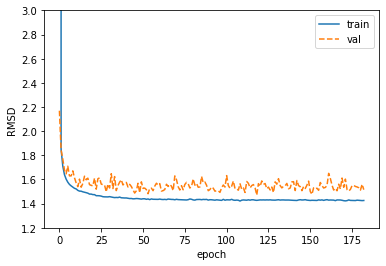

In [9]:
train_loss = losses['train_losses']
val_loss = losses['val_lossers']
cdr_rmsd = losses['cdr_rmsd']

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1.2,3))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-1804-Adam-1.png')

cdr_rmsd = np.array(cdr_rmsd)
min_i = np.where(cdr_rmsd[:,2] == np.amin(cdr_rmsd[:,2]))
print('cdr rmsd after 200 epochs', cdr_rmsd[min_i])

**3.3 Model trained on 1804, 5 decoys, Adam optimiser, batch size 1**

cdr rmsd after 40 epochs [[1.52510417 1.61094975 3.73747039 1.76834273 0.9400447  1.68899775]]


,H1,H2,H3,L1,L2,L3
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,1.53,1.61,3.74,1.77,0.94,1.69
Δ,0.63,0.58,1.29,1.16,0.43,0.76


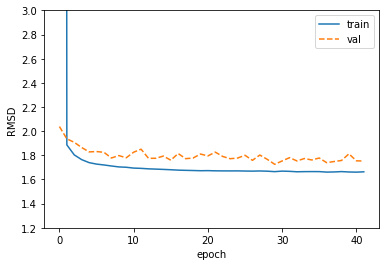

In [10]:
with open('training_loss-1804-Adam-5.json', 'r') as f:
    losses = json.load(f)
    
train_loss = losses['train_losses']
val_loss = losses['val_lossers']
cdr_rmsd = losses['cdr_rmsd']

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1.2,3))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-1804-Adam-5.png')

cdr_rmsd = np.array(cdr_rmsd)
min_i = np.where(cdr_rmsd[:,2] == np.amin(cdr_rmsd[:,2]))
print('cdr rmsd after 40 epochs', cdr_rmsd[min_i])
compare(cdr_rmsd[min_i])

**3.4 Model trained on 2004, 1 decoy, RAdam optimiser, batch size 1**

best H3 RMSD: [[1.2348038  1.16017008 2.53292561 1.41869283 0.65662473 1.20161092]]
RMSDs at min loss: [[1.17606091 1.19685483 2.65841818 1.17380047 0.59669787 1.20862103]]


,H1,H2,H3,L1,L2,L3
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,1.18,1.20,2.66,1.17,0.60,1.21
Δ,0.28,0.17,0.21,0.56,0.09,0.28


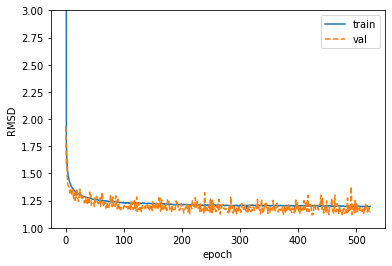

In [11]:
with open('training_loss-2004-RAdam-1.json', 'r') as f:
    losses = json.load(f)

with open('training_loss-2004-RAdam-1-cont.json', 'r') as f:
    losses2 = json.load(f)

train_loss = losses['train_losses'] + losses2['train_losses']
val_loss = losses['val_lossers'] + losses2['val_lossers']
cdr_rmsd = losses['cdr_rmsd'] + losses2['cdr_rmsd']

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1,3))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-2004-RAdam-1.png')

cdr_rmsd = np.array(cdr_rmsd)
min_h3_i = np.where(cdr_rmsd[:,2] == np.amin(cdr_rmsd[:,2]))
print(f'best H3 RMSD: {cdr_rmsd[min_h3_i]}')
min_val_loss_i = np.where(val_loss == np.amin(val_loss))
print(f'RMSDs at min loss: {cdr_rmsd[min_val_loss_i]}')

compare(cdr_rmsd[min_val_loss_i])

**3.5 Model trained on 2104, 1 decoy, RAdam optimiser, batch size 1**

best H3 RMSD: [[1.0093298  1.16636574 2.48741436 1.10044527 0.55545175 1.08139193]]
RMSDs at min loss: [[0.96472639 1.04757833 2.51226974 1.03510273 0.51013428 1.04106176]]


,H1,H2,H3,L1,L2,L3
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,0.96,1.05,2.51,1.04,0.51,1.04
Δ,0.06,0.02,0.06,0.43,0.00,0.11


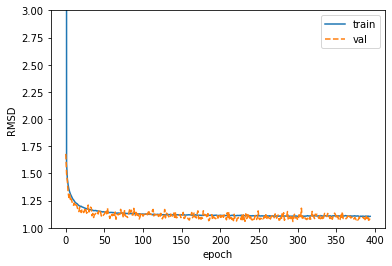

In [12]:
with open('training_loss-2104-RAdam-1.json', 'r') as f:
    losses = json.load(f)

train_loss = losses['train_losses']
val_loss = losses['val_lossers']
cdr_rmsd = losses['cdr_rmsd']

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1,3))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-2104-RAdam-1.png')

cdr_rmsd = np.array(cdr_rmsd)
min_h3_i = np.where(cdr_rmsd[:,2] == np.amin(cdr_rmsd[:,2]))
print(f'best H3 RMSD: {cdr_rmsd[min_h3_i]}')
min_val_loss_i = np.where(val_loss == np.amin(val_loss))
print(f'RMSDs at min loss: {cdr_rmsd[min_val_loss_i]}')

compare(cdr_rmsd[min_val_loss_i])

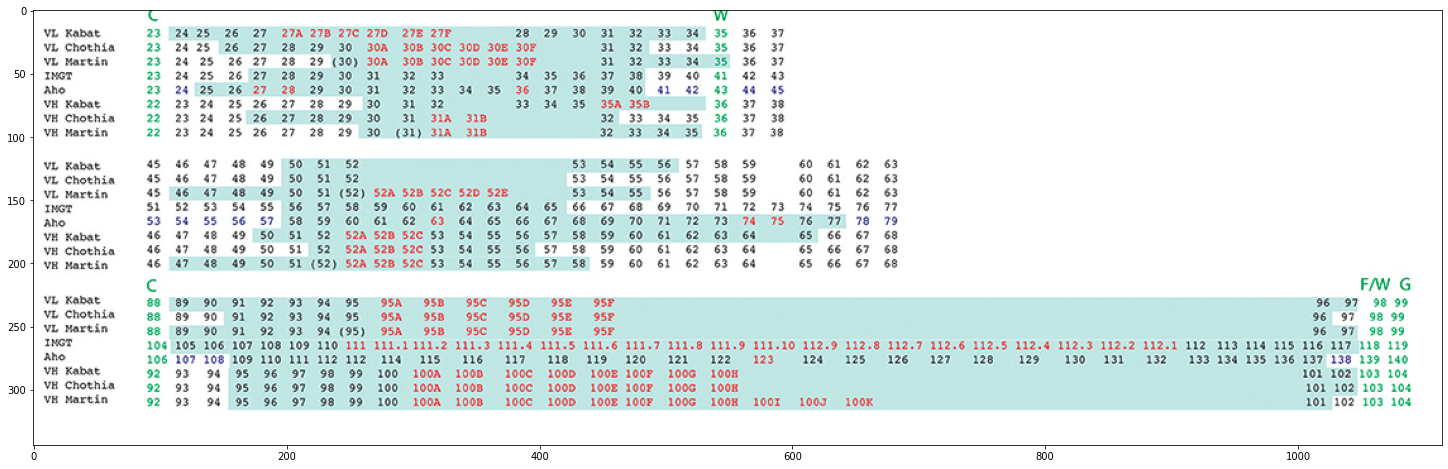

In [56]:
import matplotlib.image as mpimg
plt.figure(figsize=(30,8))
plt.imshow(mpimg.imread('figures/numbering_schemes.png'))

**3.6 Model trained on 2204, 5 decoys, RAdam optimiser, batch size 1 -- CDR RMSDs not correctly calculated check retrain notebook for proper values**

,H1,H2,H3,L1,L2,L3
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,1.43,1.42,2.98,1.67,0.86,1.49
Δ,0.53,0.39,0.53,1.06,0.35,0.56
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,1.41,1.41,2.98,1.69,0.82,1.46
Δ,0.51,0.38,0.53,1.08,0.31,0.53
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,1.42,1.43,2.96,1.63,0.88,1.48
Δ,0.52,0.40,0.51,1.02,0.37,0.55


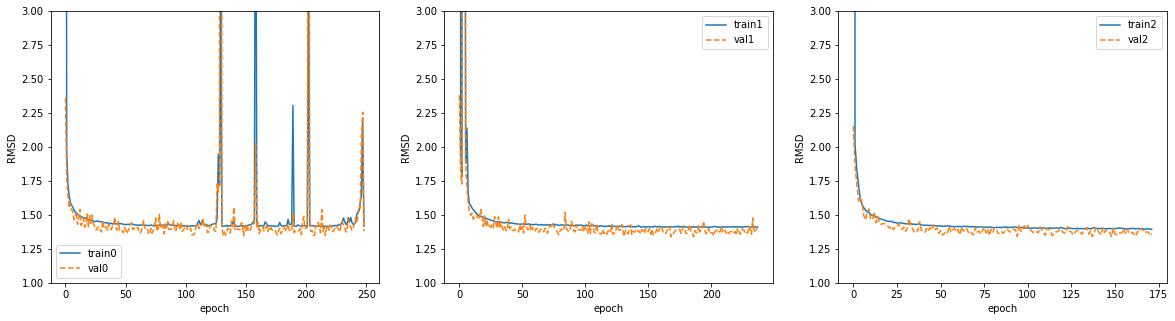

In [3]:
with open('training_loss-2204-RAdam-5-1.json', 'r') as f:
    losses1 = json.load(f)

with open('training_loss-2204-RAdam-5-2.json', 'r') as f:
    losses2 = json.load(f)

with open('training_loss-2204-RAdam-5-3.json', 'r') as f:
    losses3 = json.load(f)


train_loss = [losses1['train_losses'], losses2['train_losses'], losses3['train_losses']]
val_loss = [losses1['val_lossers'], losses2['val_lossers'], losses3['val_lossers']]
cdr_rmsds = [losses1['cdr_rmsd'], losses2['cdr_rmsd'], losses3['cdr_rmsd']]

fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
    axs[i].plot(train_loss[i], label='train' +str(i))
    axs[i].plot(val_loss[i], '--', label='val' +str(i))

    axs[i].set_ylim((1,3))
    axs[i].legend()
    axs[i].set_ylabel('RMSD')
    axs[i].set_xlabel('epoch')
    
fig.savefig('figures/train_val_losses-2204-RAdam-5.png')

comp = []
for i in range(3):
    cdr_rmsd = np.array(cdr_rmsds[i])
    min_val_loss_i = np.where(val_loss[i] == np.amin(val_loss[i]))

    comp.append(compare(cdr_rmsd[min_val_loss_i]))

comp[0].append(comp[1]).append(comp[2])

**3.6 Model trained on 2204, 3 decoys, RAdam optimiser, batch size 1**

,H1,H2,H3,L1,L2,L3
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,1.17,1.21,2.86,1.32,0.62,1.27
Δ,0.27,0.18,0.41,0.71,0.11,0.34
Chothia,0.90,1.03,2.45,0.61,0.51,0.93
IMGT,1.17,1.23,2.84,1.30,0.60,1.25
Δ,0.27,0.20,0.39,0.69,0.09,0.32


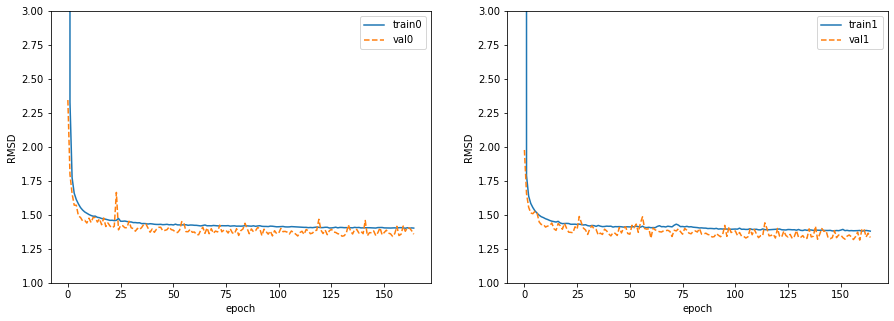

In [3]:
with open('losses/training_loss-2504-RAdam-5-1.json', 'r') as f:
    losses1 = json.load(f)

with open('losses/training_loss-2504-RAdam-5-2.json', 'r') as f:
    losses2 = json.load(f)


train_loss = [losses1['train_losses'], losses2['train_losses']]
val_loss = [losses1['val_lossers'], losses2['val_lossers']]
cdr_rmsds = [losses1['cdr_rmsd'], losses2['cdr_rmsd']]

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for i in range(2):
    axs[i].plot(train_loss[i], label='train' +str(i))
    axs[i].plot(val_loss[i], '--', label='val' +str(i))

    axs[i].set_ylim((1,3))
    axs[i].legend()
    axs[i].set_ylabel('RMSD')
    axs[i].set_xlabel('epoch')
    
fig.savefig('figures/train_val_losses-2504-RAdam-5.png')

comp = []
df = pd.DataFrame()
for i in range(2):
    cdr_rmsd = np.array(cdr_rmsds[i])
    min_val_loss_i = np.where(val_loss[i] == np.amin(val_loss[i]))

    comp.append(compare(cdr_rmsd[min_val_loss_i]))
comp[0].append(comp[1])